In [16]:
using Gridap
using GridapMakie, GLMakie
using FileIO
#mkdir("models")
#mkdir("images")
using GridapGmsh

In [17]:
model = GmshDiscreteModel("cascara_10_4.msh")
#model = GmshDiscreteModel("cascara_10_2.msh")
#fn = "model.json"
#to_json_file(model,fn)

Info    : Reading 'cascara_10_4.msh'...
Info    : 13 entities
Info    : 7161 nodes
Info    : 39355 elements
Info    : Done reading 'cascara_10_4.msh'


UnstructuredDiscreteModel()

In [18]:
Ω = Triangulation(model)

UnstructuredGrid()

In [42]:
degree = 2
dΩ = Measure(Ω,degree)

Measure()

In [43]:
writevtk(Ω,"sphere")

(["sphere.vtu"],)

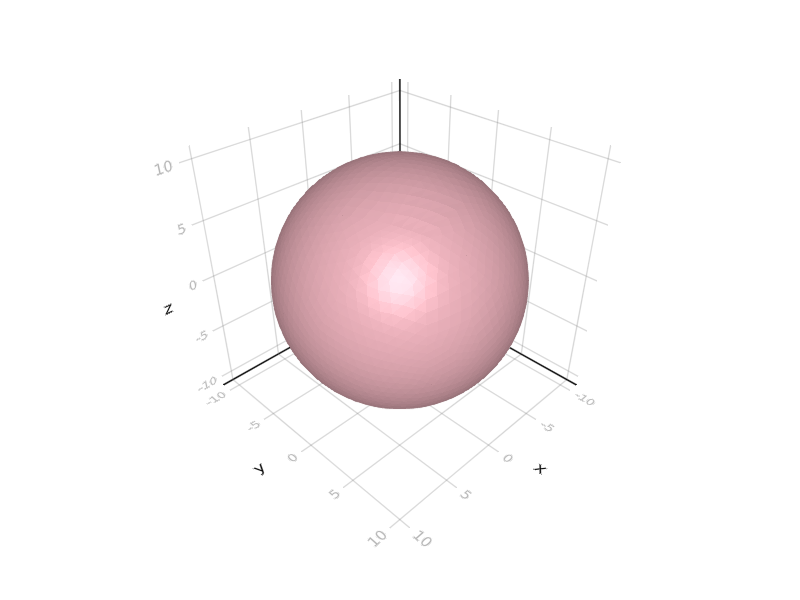

In [44]:
fig = plot(Ω, shading=true)
#wireframe!(∂Ω, color=:black)
#save("images/3d_sphere", fig)

In [45]:
order = 1
reffe = ReferenceFE(lagrangian,Float64,order)
#V = TestFESpace(model,reffe,dirichlet_tags=["int","ext"])
V = TestFESpace(model,reffe;conformity=:H1,dirichlet_tags="int")

UnconstrainedFESpace()

In [46]:
test1=false
test2=false
test3=true

true

In [55]:
if test1 || test2
    g(x) = 2. # internal boundary condition
elseif test3    
    g(x) = 2.0 + 1.1*x[3]/sqrt(x[1]^2 + x[2]^2 + x[3]^2) # internal boundary condition
end
U = TrialFESpace(V,g)

TrialFESpace()

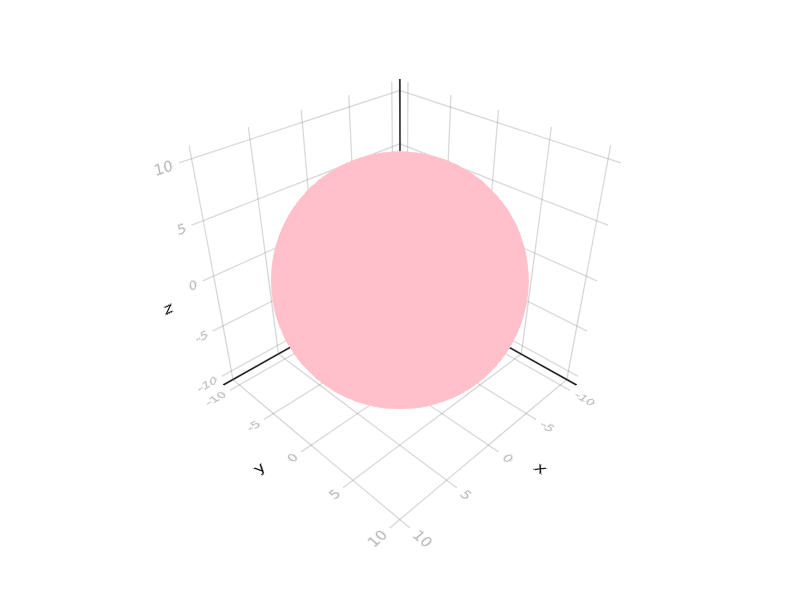

In [56]:
neumanntags = "ext"
Γ = BoundaryTriangulation(model,tags=neumanntags)
dΓ = Measure(Γ,degree)
fig = plot(Γ
    #, shading=true
    )

### Test 1: ###

We first test with given boundary values: $\phi = 2$ at $R_{min}$ and $\nabla \phi = \frac{1}{R_{max}}$ at $R_{max}$. The solution is: 

$$
\phi(r) = \frac{a}{r} + b \;\;\;\;\;\;\; \hat{n} \cdot \nabla \phi = -\frac{a}{r^2}
$$ 

From which, $a = - R_{max}$ and $b = 2 + \frac{R_{max}}{R_{min}}$

This gives, $\phi_{R_{max}} = 4.5$. And it is OK

### Test 2: ###

We now impose Robin BC. 

$$
\hat{n} \cdot \nabla \phi = -\frac{\phi}{r} \;\;\;\; \mbox{at} \;\; r = R_{max}
$$

For this case, $\phi = \frac{a}{r}$ and so, $\phi(R_{min} = 2$ implies $a = 2R_{min}$, 
and so $ \phi(R_{max}) = \frac{2R_{min}}{R_{max}}$.

The weak form is:

$$
\int_{\Omega} \nabla v \cdot \nabla \phi \; d\Omega + \oint_{\partial \Omega} v \frac{\phi}{r} \; d\Gamma
$$

$$
\int_{\Omega}  v \Delta \phi \; d\Omega + \oint_{\partial \;\Omega} v \;(\hat{n} \cdot \nabla \phi + \frac{\phi}{r})\; d\Gamma
$$

Test2 passed! OK





In [57]:
if test1
    R_ext = 10.
    R_int = 4.
    f(x) = 0.0 # source
    h(x) = 1.0/R_ext #external Neumann bc.
    a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
    b(v) = ∫( v*f )*dΩ + ∫( v*h )*dΓ
end

if test2 || test3
    R_ext = 10.
    R_int = 4.
    f(x) = 0.0 # source
    h(x) = -1.0/R_ext #external Neumann bc.
    a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ - ∫( v*h*u )*dΓ
    b(v) = ∫( v*f )*dΩ 
end

b (generic function with 1 method)

In [58]:
op = AffineFEOperator(a,b,U,V)


AffineFEOperator()

In [59]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [60]:
uh = solve(solver,op)

SingleFieldFEFunction():
 num_cells: 33179
 DomainStyle: ReferenceDomain()
 Triangulation: UnstructuredGrid()
 Triangulation id: 14922518958883297978

In [61]:
if test1 
    writevtk(Ω,"results_test1",cellfields=["uh"=>uh])
elseif test2
    writevtk(Ω,"results_test2",cellfields=["uh"=>uh])
elseif test3
    writevtk(Ω,"results_test3",cellfields=["uh"=>uh])
end

(["results_test3.vtu"],)

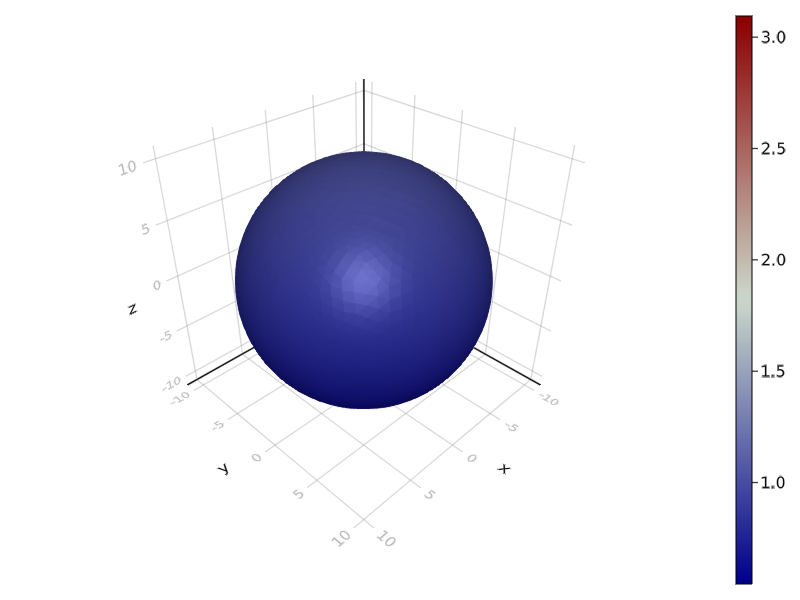

In [62]:
fig, ax, plt = plot(Ω, uh, shading=true)
Colorbar(fig[1,2], plt)
#save("images/3d_Fig2.png", fig)
fig